# Analysis

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

In [2]:
# Încărcarea datelor
df = spark.read.csv("ChurnModelling.csv", header=True, inferSchema=True)
df.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|     Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93

In [3]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [4]:
# Eliminarea valorilor duplicate
df = df.dropDuplicates()

In [5]:
from pyspark.sql.functions import col, when, isnan, count

# Verificarea valorilor lipsă
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [6]:
# Count of Exited values
df.groupBy("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



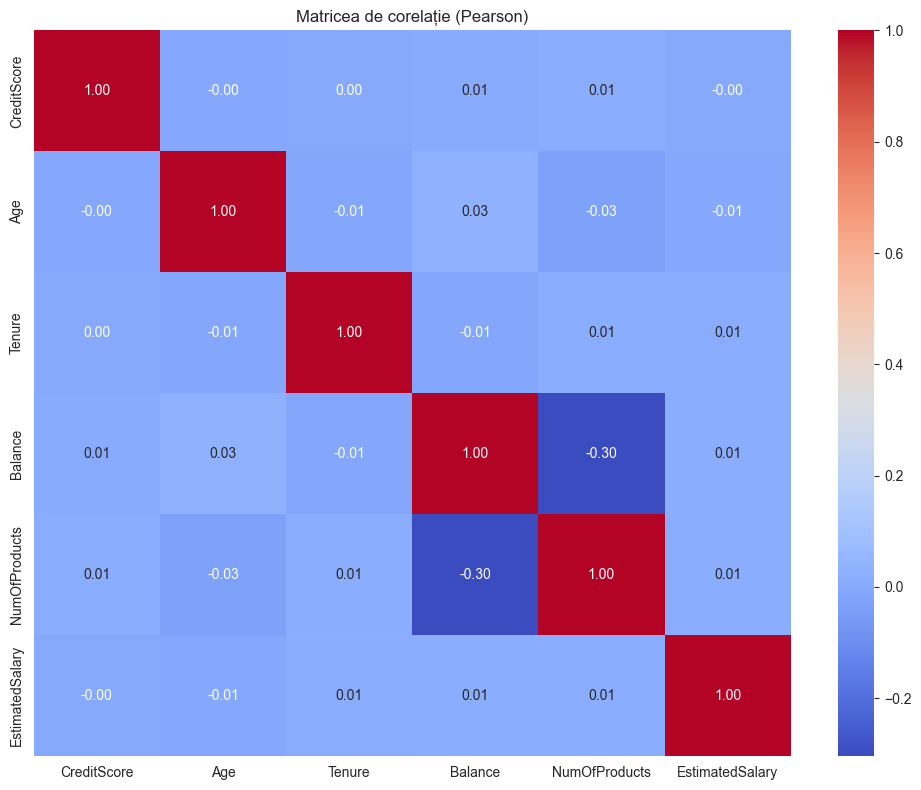

In [7]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorizarea coloanelor numerice
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_vec = vec_assembler.transform(df)

# Calculul corelației Pearson
cor_matrix = Correlation.corr(df_vec, "features", method="pearson").head()[0]

# Conversia matricei DenseMatrix într-un array numpy
corr_array = cor_matrix.toArray()

# Crearea unui DataFrame Pandas frumos cu etichete
corr_df = pd.DataFrame(corr_array, index=num_cols, columns=num_cols)

# Vizualizare
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matricea de corelație (Pearson)")
plt.tight_layout()
plt.show()

In [8]:
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, StandardScaler
)

# Codificare variabile categorice
indexer = StringIndexer(inputCols=["Geography", "Gender"], outputCols=["GeographyIndex", "GenderIndex"])
df_indexed = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=["GeographyIndex", "GenderIndex"],
                        outputCols=["GeographyVec", "GenderVec"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)
df_encoded.show()

+---------+----------+-----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+-------------+-------------+
|RowNumber|CustomerId|          Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GeographyIndex|GenderIndex| GeographyVec|    GenderVec|
+---------+----------+-----------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+-------------+-------------+
|      130|  15591607|           Fernie|        770|   France|  Male| 24|     9|101827.07|            1|        1|             0|      167256.35|     0|           0.0|        0.0|(2,[0],[1.0])|(1,[0],[1.0])|
|      360|  15592386|         Campbell|        520|   France|  Male| 58|     3|      0.0|            2|        0|             1|       32790.02|     0|           0.0| 

In [9]:
# Feature Engineering
df_fe = df_encoded.withColumn("BalanceToSalaryRatio", col("Balance") / (col("EstimatedSalary") + 1))
df_fe = df_fe.withColumn("IsSenior", when(col("Age") > 60, 1).otherwise(0))
df_fe = df_fe.withColumn("EngagementScore", col("NumOfProducts") + col("IsActiveMember") + (1 - col("HasCrCard")))
df_fe = df_fe.withColumn("HasZeroBalance", when(col("Balance") == 0, 1).otherwise(0))

In [10]:
from pyspark.sql.functions import col, when

# 1. Sold mediu per produs (evităm împărțirea la zero)
df = df.withColumn(
    "AverageBalancePerProduct",
    when(col("NumOfProducts") == 0, 0)
    .otherwise(col("Balance") / col("NumOfProducts"))
)

# 2. Indicator de client loial și activ
df = df.withColumn(
    "LoyalActiveCustomer",
    col("Tenure") * col("IsActiveMember")
)

# Verificăm noile coloane
df.select("Balance", "NumOfProducts", "AverageBalancePerProduct", "Tenure", "IsActiveMember", "LoyalActiveCustomer").show(5)

+---------+-------------+------------------------+------+--------------+-------------------+
|  Balance|NumOfProducts|AverageBalancePerProduct|Tenure|IsActiveMember|LoyalActiveCustomer|
+---------+-------------+------------------------+------+--------------+-------------------+
|101827.07|            1|               101827.07|     9|             0|                  0|
|      0.0|            2|                     0.0|     3|             1|                  3|
|209767.31|            2|              104883.655|     2|             1|                  2|
|129748.54|            2|                64874.27|     2|             0|                  0|
|174912.72|            1|               174912.72|     6|             1|                  6|
+---------+-------------+------------------------+------+--------------+-------------------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import col, when

df = df.withColumn(
    "AverageBalancePerProduct",
    when(col("NumOfProducts") == 0, 0)
    .otherwise(col("Balance") / col("NumOfProducts"))
)

df = df.withColumn(
    "LoyalActiveCustomer",
    col("Tenure") * col("IsActiveMember")
)

In [12]:
# Standardizare variabile numerice
vec_features = VectorAssembler(
    inputCols=["CreditScore", "BalanceToSalaryRatio", "EstimatedSalary", "Tenure", "EngagementScore"],
    outputCol="unscaledFeatures"
)
df_unscaled = vec_features.transform(df_fe)

scaler = StandardScaler(inputCol="unscaledFeatures", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_unscaled)
df_scaled = scaler_model.transform(df_unscaled)

In [13]:
# Împărțirea în seturi de antrenare și testare
train_data, test_data = df_scaled.randomSplit([0.7, 0.3], seed=42)
train_data.show()

+---------+----------+-------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+-------------+-------------+--------------------+--------+---------------+--------------+--------------------+--------------------+
|RowNumber|CustomerId|      Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GeographyIndex|GenderIndex| GeographyVec|    GenderVec|BalanceToSalaryRatio|IsSenior|EngagementScore|HasZeroBalance|    unscaledFeatures|      scaledFeatures|
+---------+----------+-------------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+-------------+-------------+--------------------+--------+---------------+--------------+--------------------+--------------------+
|        1|  15634602|     Hargrave|        619|   France|Female| 42|     2|   

# Linear Regression

## H1

In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

cols_H1 = ["Age", "EstimatedSalary", "Tenure", "NumOfProducts", "HasCrCard"]
vec_assembler_h1 = VectorAssembler(inputCols=cols_H1, outputCol="features_H1")
df_h1 = vec_assembler_h1.transform(df).select("features_H1", "Balance")

# Model H1
lr_h1 = LinearRegression(featuresCol="features_H1", labelCol="Balance")
model_h1 = lr_h1.fit(df_h1)

print("Rezultate H1")
print(f"R2: {model_h1.summary.r2}")
print(f"RMSE: {model_h1.summary.rootMeanSquaredError}")

Rezultate H1
R2: 0.09342647285642658
RMSE: 59408.191338902456


In [15]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


model_h1 = LinearRegression(featuresCol="features_H1", labelCol="Balance")
evaluator = RegressionEvaluator(labelCol="Balance", predictionCol="prediction", metricName="r2")

paramGrid = ParamGridBuilder() \
    .addGrid(model_h1.regParam, [0.0, 0.1, 0.2]) \
    .addGrid(model_h1.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(model_h1.maxIter, [10, 50, 100]) \
    .build()

cv = CrossValidator(estimator=model_h1,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

cvModel = cv.fit(df_h1)
predictions = cvModel.transform(df_h1)
r2 = evaluator.evaluate(predictions)
rmse = RegressionEvaluator(labelCol="Balance", metricName="rmse").evaluate(predictions)

print(f"Best model R²: {r2:.4f}")
print(f"Best model RMSE: {rmse:.2f}")

Best model R²: 0.0934
Best model RMSE: 59408.19


## H2

In [15]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Geography", outputCol="GeographyIndexed")
df = indexer.fit(df).transform(df)

cols_H2 = ["IsActiveMember", "GeographyIndexed", "CreditScore", "EstimatedSalary"]

vec_assembler_h2 = VectorAssembler(inputCols=cols_H2, outputCol="features_H2")
df_h2 = vec_assembler_h2.transform(df).select("features_H2", "Balance")

lr_h2 = LinearRegression(featuresCol="features_H2", labelCol="Balance")
model_h2 = lr_h2.fit(df_h2)

print("Rezultate H2")
print(f"R2: {model_h2.summary.r2}")
print(f"RMSE: {model_h2.summary.rootMeanSquaredError}")

Rezultate H2
R2: 0.005128043026429774
RMSE: 62234.09934041656


In [16]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


model_h2 = LinearRegression(featuresCol="features_H2", labelCol="Balance")
evaluator = RegressionEvaluator(labelCol="Balance", predictionCol="prediction", metricName="r2")

paramGrid = ParamGridBuilder() \
    .addGrid(model_h2.regParam, [0.0, 0.1, 0.2]) \
    .addGrid(model_h2.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(model_h2.maxIter, [10, 50, 100]) \
    .build()

cv = CrossValidator(estimator=model_h2,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

cvModel = cv.fit(df_h2)
predictions = cvModel.transform(df_h2)
r2 = evaluator.evaluate(predictions)
rmse = RegressionEvaluator(labelCol="Balance", metricName="rmse").evaluate(predictions)

print(f"Best model R²: {r2:.4f}")
print(f"Best model RMSE: {rmse:.2f}")

KeyboardInterrupt: 

# Decision Tree

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="Exited", featuresCol="scaledFeatures", maxDepth=5)
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Exited", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"✅ Acuratețea modelului Decision Tree: {accuracy:.4f}")

✅ Acuratețea modelului Decision Tree: 0.8070


# Random Forest

In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Exited", featuresCol="scaledFeatures", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")

rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Acuratețea Random Forest: {rf_accuracy:.4f}")

rf_predictions.select("Exited", "prediction", "probability").show(10, truncate=False)
for idx, importance in enumerate(rf_model.featureImportances):
    print(f"Feature {idx}: {importance:.4f}")

Acuratețea Random Forest: 0.8080
+------+----------+----------------------------------------+
|Exited|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |0.0       |[0.8056411121785289,0.19435888782147123]|
|0     |0.0       |[0.8845786357833165,0.11542136421668348]|
|0     |0.0       |[0.7943508861343599,0.2056491138656402] |
|0     |0.0       |[0.810756530283223,0.18924346971677705] |
|0     |0.0       |[0.8609722052509492,0.1390277947490508] |
|0     |0.0       |[0.8837604236261853,0.11623957637381471]|
|0     |0.0       |[0.8036229407057875,0.19637705929421256]|
|0     |0.0       |[0.8837604236261853,0.11623957637381471]|
|0     |0.0       |[0.8817873843019494,0.11821261569805053]|
|0     |0.0       |[0.8797028324262287,0.12029716757377132]|
+------+----------+----------------------------------------+
only showing top 10 rows

Feature 0: 0.0607
Feature 1: 0.1646
Feature 2: 0.0625
Feature 3: 0.0487
Feature 4: 0.66

# Gradient Boosting

In [20]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Exited", featuresCol="scaledFeatures", maxIter=50, maxDepth=5)
gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")

gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print(f"Acuratețea Gradient Boosted Trees: {gbt_accuracy:.4f}")

gbt_predictions.select("Exited", "prediction", "probability").show(10, truncate=False)

Acuratețea Gradient Boosted Trees: 0.8008
+------+----------+----------------------------------------+
|Exited|prediction|probability                             |
+------+----------+----------------------------------------+
|1     |0.0       |[0.8163430302529538,0.18365696974704615]|
|0     |0.0       |[0.9217178501340414,0.0782821498659586] |
|0     |0.0       |[0.6267977358851978,0.3732022641148022] |
|0     |0.0       |[0.8273791237639765,0.1726208762360235] |
|0     |0.0       |[0.8320041768949538,0.16799582310504624]|
|0     |0.0       |[0.9037331722063136,0.09626682779368645]|
|0     |0.0       |[0.7089597345915557,0.2910402654084443] |
|0     |0.0       |[0.9275451452229487,0.07245485477705127]|
|0     |0.0       |[0.8965384905216686,0.10346150947833144]|
|0     |0.0       |[0.9128474953615452,0.08715250463845481]|
+------+----------+----------------------------------------+
only showing top 10 rows



# Logistic Regression

In [21]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="Exited", featuresCol="scaledFeatures", maxIter=100)
lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")

lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"Acuratețea Logistic Regression: {lr_accuracy:.4f}")

print("Coeficienți:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

Acuratețea Logistic Regression: 0.8032
Coeficienți: [-0.05275177856610771,0.1679612933398506,0.06999779083569614,-0.032198228200976044,-0.3179576334803355]
Intercept: -0.2669687774481062


# Regression with tries
## H1

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

cols_H1 = ["Age", "EstimatedSalary", "Tenure", "NumOfProducts", "HasCrCard"]
vec_assembler_h1 = VectorAssembler(inputCols=cols_H1, outputCol="features_H1")
df_h1 = vec_assembler_h1.transform(df).select("features_H1", "Balance")
train_h1, test_h1 = df_h1.randomSplit([0.7, 0.3], seed=42)
dt_h1 = DecisionTreeRegressor(featuresCol="features_H1", labelCol="Balance", maxDepth=5)
model_h1 = dt_h1.fit(train_h1)
predictions_h1 = model_h1.transform(test_h1)

evaluator_r2 = RegressionEvaluator(
    labelCol="Balance", predictionCol="prediction", metricName="r2"
)
evaluator_mse = RegressionEvaluator(
    labelCol="Balance", predictionCol="prediction", metricName="mse"
)

r2_h1 = evaluator_r2.evaluate(predictions_h1)
mse_h1 = evaluator_mse.evaluate(predictions_h1)

print("Rezultate Decision Tree Regressor - H1:")
print(f"R²: {r2_h1:.4f}")
print(f"MSE: {mse_h1:.2f}")

Rezultate Decision Tree Regressor - H1:
R²: 0.1345
MSE: 3371909632.63


## H2

In [32]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

cols_H2 = ["IsActiveMember", "GeographyIndexed", "CreditScore", "EstimatedSalary"]
vec_assembler_h2 = VectorAssembler(inputCols=cols_H2, outputCol="features_H2")
df_h2 = vec_assembler_h2.transform(df).select("features_H2", "Balance")
train_h2, test_h2 = df_h2.randomSplit([0.7, 0.3], seed=42)
dt_h2 = DecisionTreeRegressor(featuresCol="features_H2", labelCol="Balance", maxDepth=5)
model_h2 = dt_h2.fit(train_h2)
predictions_h2 = model_h2.transform(test_h2)
evaluator_r2_h2 = RegressionEvaluator(labelCol="Balance", predictionCol="prediction", metricName="r2")
evaluator_mse_h2 = RegressionEvaluator(labelCol="Balance", predictionCol="prediction", metricName="mse")

r2_h2 = evaluator_r2_h2.evaluate(predictions_h2)
mse_h2 = evaluator_mse_h2.evaluate(predictions_h2)

print("Rezultate Decision Tree Regressor - H2:")
print(f"R²: {r2_h2:.4f}")
print(f"MSE: {mse_h2:.2f}")

Rezultate Decision Tree Regressor - H2:
R²: 0.1594
MSE: 3265161897.31
